In [1]:
import time
import keras 
import tensorflow 
import numpy as np , matplotlib.pyplot as plt, cv2 ,os
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout ,Activation
from keras.layers import concatenate, Conv2DTranspose, BatchNormalization
from keras import backend as K
import warnings
warnings.filterwarnings("ignore")
import keras.models as models
from keras.layers import Input
img_rows = 224
img_cols = 224
channels =  3
input_sha = Input((img_rows, img_cols, channels))
from tqdm import tqdm
dim  = (img_rows,img_cols)
import pickle
from pickle import load
stride_size = 1
size_pool = 2
filter_size = 32
kernel = 3
pool_size = 2

data_shape = 224*224

def label_img(img):
    img = img.copy()
    background = [128,128,128]
    crop = [128,0,0]
    weed = [192,192,128]


    label_colours = np.array([background,crop,weed])

    categorical_to_id = [0, 1, 2]

    if img.ndim < 3 or img.shape[-1] == 1:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    for l in range(len(categorical_to_id)):
        img[np.where((img == [l, l, l]).all(axis=-1))] = label_colours[l]
    return img


def binarylab(labels):
    x = np.zeros([224,224,3])    
    for i in range(224):
        for j in range(224):
            x[i,j,labels[i][j]]=1
    return x



def fire_module(x, fire_id, squeeze, expand):
    f_name = "fire{0}/{1}"
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    x = Conv2D(squeeze, (1, 1) , padding='same',activation='relu', name=f_name.format(fire_id, "squeeze1x1"))(x)
    x = BatchNormalization()(x)
  
    left = Conv2D(expand, (1, 1), padding='same', name=f_name.format(fire_id, "expand1x1"))(x)
    right = Conv2D(expand, (3, 3) , padding='same', name=f_name.format(fire_id, "expand3x3"))(x)
    x = concatenate([left, right], axis=channel_axis, name=f_name.format(fire_id, "concat"))
    return x


train_label = load(open('/content/drive/My Drive/Squee_weed_label','rb'))
train_data = load(open('/content/drive/My Drive/Squee_weed','rb'))

print(train_label.shape , type(train_label))    #for annotated image
print(train_data.shape , type(train_data))      #for RGB image

Using TensorFlow backend.




(389, 224, 224, 3) <class 'numpy.ndarray'>
(389, 224, 224, 3) <class 'numpy.ndarray'>


In [3]:
x = Conv2D(64,kernel, kernel, border_mode='same' ) (input_sha)                  #convolution layer by giving the input shape 
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(64, kernel, kernel, border_mode='same', activation='relu')(x)        #added one layer 
x = BatchNormalization()(x)

x = Conv2D(64, kernel, kernel, border_mode='same', activation='relu')(x)   
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(pool_size, pool_size))(x)                           #first maxpool


x = Conv2D(128, kernel, kernel, border_mode='same', activation='relu')(x)   
x =BatchNormalization()(x)
x =MaxPooling2D(pool_size=(pool_size, pool_size))(x)                            #second maxpool


x =Conv2D(256, kernel, kernel, border_mode='same', activation='relu')(x) 
x =BatchNormalization()(x)
x =MaxPooling2D(pool_size=(pool_size, pool_size))(x)                            #third maxpool
                                                     #squeezenet layer  with 16 squeeze and expand with 64 

x =Conv2D(256, kernel, kernel, border_mode='same', activation='relu')(x)   
x =BatchNormalization()(x)
x =UpSampling2D(size=(pool_size, pool_size))(x)                                 #first upsamp


x =Conv2D(128, kernel, kernel, border_mode='same', activation='relu')(x)  
x =BatchNormalization()(x)
x =UpSampling2D(size=(pool_size, pool_size))(x)                                 #second upsamp


x =Conv2D(64, kernel, kernel, border_mode='same', activation='relu')(x)    
x =BatchNormalization()(x)
x =UpSampling2D(size=(pool_size, pool_size))(x)                                 #third upsamp

x =Conv2D(64, kernel, kernel, border_mode='same', activation='relu')(x)         #added one layer
x =BatchNormalization()(x)

x =Conv2D(3, 1, 1, border_mode='same')(x)
x =Activation('softmax')(x)


model = Model(inputs=input_sha, outputs=x)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
batch_normalization_10 (Batc (None, 224, 224, 64)      256       
_________________________________________________________________
activation_3 (Activation)    (None, 224, 224, 64)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
batch_normalization_11 (Batc (None, 224, 224, 64)      256       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 224, 224, 64)      3692

In [4]:
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])
start_time = time.time()
model.fit(train_data,train_label,   validation_split=0.002, batch_size=5 , epochs=80)
print("--- %s seconds ---" % (time.time() - start_time))



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 388 samples, validate on 1 samples
Epoch 1/80
388/388 [==============================] - 21s 54ms/step - loss: 0.9005 - acc: 0.7030 - val_loss: 0.8363 - val_acc: 0.6989
Epoch 2/80
388/388 [==============================] - 9s 23ms/step - loss: 0.5403 - acc: 0.8536 - val_loss: 0.8166 - val_acc: 0.7386
Epoch 3/80
388/388 [==============================] - 9s 23ms/step - loss: 0.4621 - acc: 0.8554 - val_loss: 1.5002 - val_acc: 0.3376
Epoch 4/80
388/388 [==============================] - 9s 23ms/step - loss: 0.4293 - acc: 0.8571 - val_loss: 0.9823 - val_acc: 0.7438
Epoch 5/80
388/388 [==============================] - 9s 24ms/step - loss: 0.3888 - acc: 0.8625 - val_loss: 1.0085 - val_acc: 0.6819
Epoch 6/80
388/388 [==============================] - 9s 24ms/step - loss: 0.3512 - acc: 0.8684 - val_loss: 0.8735 - val_acc: 0.7624
Epoch 7/80
388/388 [==============================] - 9s 24

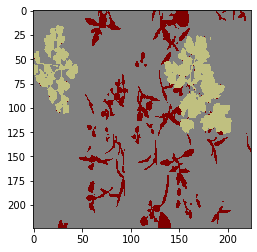

In [0]:
img = cv2.imread('/content/drive/My Drive/data_set/train_data/train set/_0_1187031.png')     
img = cv2.resize(img,dim)
masks = model.predict(np.expand_dims(img, axis=0), verbose=0)
masks = np.argmax(masks[0], axis=2).astype(np.uint8)
masks = label_img(masks)
plt.imshow(masks)

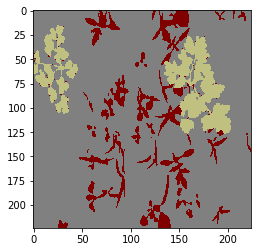

In [0]:
img = cv2.imread('/content/drive/My Drive/data_set/train_data/train set/_0_1187031.png')     #with 35 epos
img = cv2.resize(img,dim)
masks = model.predict(np.expand_dims(img, axis=0), verbose=0)
masks = np.argmax(masks[0], axis=2).astype(np.uint8)
masks = label_img(masks)
plt.imshow(masks)

Text(0.5, 0, 'epoch')

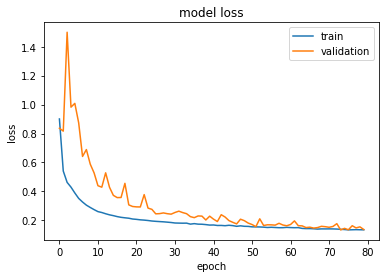

In [6]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.legend(['train', 'validation'], loc='upper right')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

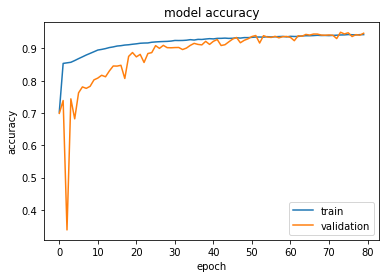

In [8]:
plt.plot(model.history.history['acc'])
plt.plot(model.history.history['val_acc'])
plt.legend(['train', 'validation'], loc='lower right')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')